In [445]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

matplotlib.rcParams.update({'font.size': 14})

In [446]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):

    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [447]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [448]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [449]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


### Приведение типов

In [450]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [451]:
train_df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

In [452]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Обзор данных

**Целевая переменная**

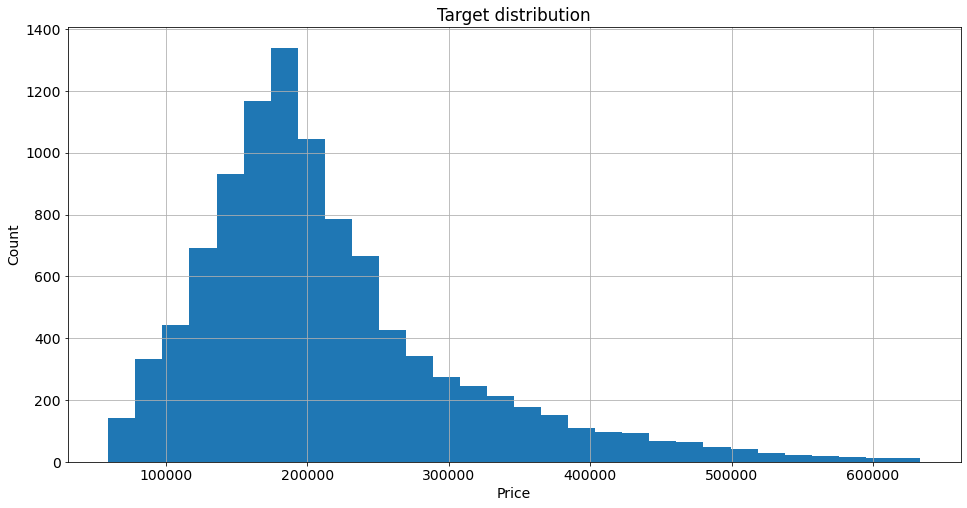

In [453]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

### Количественные переменные

In [454]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [455]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

### Обработка выбросов

**Rooms**

In [456]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [457]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

**Square, LifeSquare, KitchenSquare**

In [458]:
np.clip(
    a=train_df["LifeSquare"].dropna(),
    a_min=20,
    a_max=150
)

0       29.442751
1       40.049543
2       29.197612
3       52.731512
4       23.776169
          ...    
9993    48.899083
9995    30.476203
9996    20.539216
9998    33.840147
9999    21.157874
Name: LifeSquare, Length: 7887, dtype: float64

In [459]:
train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.99)) &
                    (train_df['Square'] > train_df['Square'].quantile(.01))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.99)) &
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.01))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) &
                    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

In [460]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [461]:
mask = train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"]
train_df.loc[mask]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
48,7596,23,1.0,47.080100,46.807989,12.0,3,9.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,96029.167877
69,6925,27,2.0,64.929103,63.304605,10.0,15,17.0,2016,0.072158,B,B,2,629,1,NaN,0,0,A,228584.001072
129,6072,6,1.0,65.102017,64.622603,1.0,10,9.0,2015,0.243205,B,B,5,1564,0,540.0,0,0,B,175899.978284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,10318,6,1.0,40.631541,38.750052,7.0,5,17.0,2013,0.243205,B,B,5,1564,0,540.0,0,0,B,131271.924425
9884,41,30,2.0,59.015896,59.439082,12.0,5,5.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,126281.142781
9897,4497,1,1.0,38.330353,38.010046,8.0,7,17.0,1991,0.025609,B,B,33,5261,0,240.0,3,1,B,97464.327338
9902,14001,73,1.0,44.098768,44.267551,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.404161


In [462]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

**HouseFloor, Floor**

In [463]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()
floor_delta_housefloor = train_df['HouseFloor'] - train_df['Floor']
floor_delta_housefloor = np.abs(floor_delta_housefloor[floor_delta_housefloor<0])
floor_delta_housefloor.value_counts().sort_index()

1.0     630
2.0     370
3.0      45
4.0      42
5.0      29
6.0      36
7.0      21
8.0      23
9.0      30
10.0     29
11.0     24
12.0     21
13.0     18
14.0     15
15.0     16
16.0     13
17.0      6
18.0      3
19.0      6
20.0      7
21.0      4
22.0      2
23.0      7
24.0      3
25.0      3
26.0      1
dtype: int64

In [464]:
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: random.randint(1, x)
)

**HouseYear**

In [465]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [466]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742


In [467]:
stats = train_df.groupby(["Rooms"])["Square"].mean()
stats

Rooms
1.0    40.816068
2.0    55.491121
3.0    74.465945
4.0    90.154614
5.0    95.086773
6.0    59.414334
Name: Square, dtype: float64

### Обработка пропусков

**LifeSquare**

In [468]:
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.490551802890103

In [469]:
test_df.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [470]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

**Healthcare_1**

In [471]:
train_df.loc[train_df["Healthcare_1"].isnull(), "Healthcare_1"] = train_df["Healthcare_1"].median()

In [472]:
train_df.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [473]:
gp = train_df.groupby(["Rooms"])["Square"].mean()
train_df["Mean_Square_by_rooms"] = train_df["Rooms"].map(gp.to_dict())

train_df["diff_square_and_mean_square_by_rooms"] = train_df["Square"] - train_df["Mean_Square_by_rooms"]
train_df["ratio_square_and_mean_square_by_rooms"] = train_df["Square"] / train_df["Mean_Square_by_rooms"] - 1
train_df.head(n=2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.08904,...,7976,5,990.0,0,11,B,184966.930730,55.491121,-7.509560,-0.135329
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.00007,...,10309,1,240.0,1,16,B,300009.450063,74.465945,-8.782305,-0.117937


In [474]:
train_df["bigger_then_mean"] = np.where(
    train_df["diff_square_and_mean_square_by_rooms"] > 0, 1, 0)
train_df.groupby(["bigger_then_mean"])["Price"].mean()

bigger_then_mean
0    197301.647237
1    233369.246666
Name: Price, dtype: float64

In [475]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,11,B,184966.930730,55.491121,-7.509560,-0.135329,0,1,1,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,16,B,300009.450063,74.465945,-8.782305,-0.117937,0,1,1,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5,B,175616.227217,55.491121,-2.138140,-0.038531,0,1,1,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,4,B,150226.531644,40.816068,-1.166876,-0.028589,0,1,1,1
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,6,B,215898.447742,74.465945,5.918534,0.079480,1,1,1,1


In [476]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,628
1,1,537
2,23,449
3,6,396
4,9,279


In [477]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,184966.930730,55.491121,-7.509560,-0.135329,0,1,1,1,20
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,300009.450063,74.465945,-8.782305,-0.117937,0,1,1,1,86
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,175616.227217,55.491121,-2.138140,-0.038531,0,1,1,1,146
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,B,150226.531644,40.816068,-1.166876,-0.028589,0,1,1,1,95
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,B,215898.447742,74.465945,5.918534,0.079480,1,1,1,1,54


In [478]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

Text(0, 0.5, 'Price')

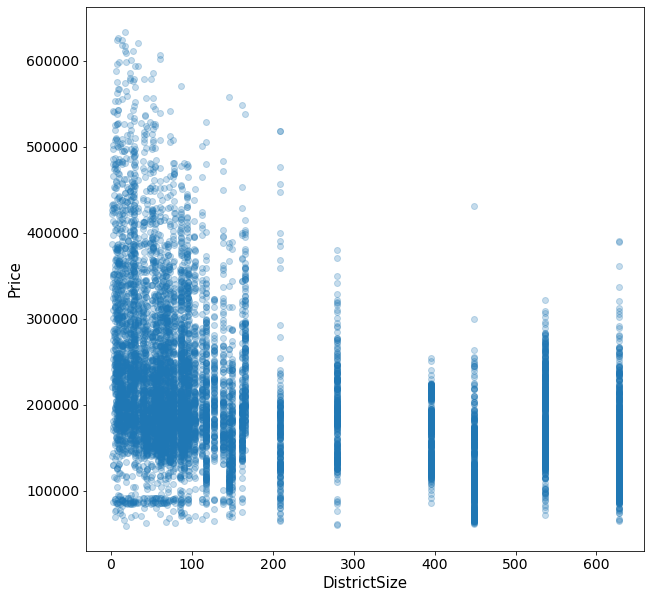

In [479]:
plt.figure(figsize=(10, 10))
plt.scatter(
    train_df["DistrictSize"], train_df["Price"], alpha=0.25
)
plt.xlabel("DistrictSize", size=15)
plt.ylabel("Price", size=15)

In [480]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,147258.736617
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146154.352249
4,1,2.0,202944.331497


In [481]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,55.491121,-7.509560,-0.135329,0,1,1,1,20,0,203384.328026
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,74.465945,-8.782305,-0.117937,0,1,1,1,86,0,300009.450063
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,55.491121,-2.138140,-0.038531,0,1,1,1,146,1,169246.115943
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,40.816068,-1.166876,-0.028589,0,1,1,1,95,0,158791.017955
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,74.465945,5.918534,0.079480,1,1,1,1,54,0,384517.540046


In [482]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)
test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          3959 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        2623 non-null   float64
 16  Helthc

In [483]:
train_df.Ecology_2

0       B
1       B
2       B
3       B
4       B
       ..
8876    B
8877    B
8878    B
8879    B
8880    B
Name: Ecology_2, Length: 8881, dtype: object

In [484]:
train_df.Ecology_3

0       B
1       B
2       B
3       B
4       B
       ..
8876    B
8877    B
8878    B
8879    A
8880    B
Name: Ecology_3, Length: 8881, dtype: object

In [485]:
train_df["Eco2_Eco3"] = train_df.Ecology_2 + train_df.Ecology_3
train_df.groupby(["Floor"])["Price"].mean()

Floor
1     193963.079237
2     204736.696571
3     199396.262369
4     213121.616557
5     216019.158184
6     216534.453839
7     226510.843857
8     217471.584071
9     220872.771426
10    214840.464391
11    220053.031852
12    210461.926238
13    223000.242113
14    233502.378406
15    237442.955930
16    222137.851399
17    220555.278836
18    260075.847877
19    229089.619988
20    244441.630235
21    227981.236707
22    275116.237965
23    244615.096203
24    209111.788474
25    313146.440310
28    224756.995229
31    117647.461002
32    393799.531732
33    389554.063540
42    411691.504766
Name: Price, dtype: float64

In [486]:
gp = train_df.Ecology_2 + train_df.Ecology_3
gp.map(gp.value_counts().to_dict())

0       8525
1       8525
2       8525
3       8525
4       8525
        ... 
8876    8525
8877    8525
8878    8525
8879     267
8880    8525
Length: 8881, dtype: int64

In [487]:
train_df["Rooms_vc"] = train_df["Rooms"].map(train_df["Rooms"].value_counts().to_dict())

In [488]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']
target_name = 'Price'

In [489]:
train_df.shape

(8881, 32)

### Разбиение на train и test

In [490]:
features = list(train_df.loc[:, train_df.columns != 'Id'].corrwith(
    train_df['Price']).abs().sort_values(ascending=False)[1:].index)

target = 'Price'

In [491]:
train_df[features].head()

,MedPriceByDistrict,Square,Mean_Square_by_rooms,Rooms,Rooms_vc,LifeSquare,DistrictSize,IsDistrictLarge,KitchenSquare,Social_1,...,Shops_1,Healthcare_1,Floor,HouseFloor,Social_3,Ecology_1,Shops_2_bin,Ecology_3_bin,Ecology_2_bin,HouseYear
0,203384.328026,47.981561,55.491121,2.0,3537,29.442751,20,0,6.0,33,...,11,990.0,7,9.0,5,0.089040,1,1,1,1969
1,300009.450063,65.683640,74.465945,3.0,1973,40.049543,86,0,8.0,46,...,16,240.0,7,9.0,1,0.000070,1,1,1,1978
2,169246.115943,53.352981,55.491121,2.0,3537,52.731512,146,1,9.0,23,...,5,1084.0,8,17.0,3,0.437885,1,1,1,1977
3,158791.017955,39.649192,40.816068,1.0,3250,23.776169,95,0,7.0,35,...,4,2078.0,11,12.0,1,0.012339,1,1,1,1976
4,384517.540046,80.384479,74.465945,3.0,1973,46.683720,54,0,12.0,35,...,6,990.0,5,17.0,4,0.309479,1,1,1,2011


In [492]:
models_dict = {}

X_train, X_test, y_train, y_test = train_test_split(
    train_df[features], train_df[target], test_size=0.3, random_state=42)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6216 entries, 3125 to 7270
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MedPriceByDistrict                     6216 non-null   float64
 1   Square                                 6216 non-null   float64
 2   Mean_Square_by_rooms                   6216 non-null   float64
 3   Rooms                                  6216 non-null   float64
 4   Rooms_vc                               6216 non-null   int64  
 5   LifeSquare                             6216 non-null   float64
 6   DistrictSize                           6216 non-null   int64  
 7   IsDistrictLarge                        6216 non-null   int32  
 8   KitchenSquare                          6216 non-null   float64
 9   Social_1                               6216 non-null   int64  
 10  Helthcare_2                            6216 non-null   int64  
 11  d

In [493]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 7810 to 7613
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MedPriceByDistrict                     2665 non-null   float64
 1   Square                                 2665 non-null   float64
 2   Mean_Square_by_rooms                   2665 non-null   float64
 3   Rooms                                  2665 non-null   float64
 4   Rooms_vc                               2665 non-null   int64  
 5   LifeSquare                             2665 non-null   float64
 6   DistrictSize                           2665 non-null   int64  
 7   IsDistrictLarge                        2665 non-null   int32  
 8   KitchenSquare                          2665 non-null   float64
 9   Social_1                               2665 non-null   int64  
 10  Helthcare_2                            2665 non-null   int64  
 11  d

In [494]:
X_train.head()

,MedPriceByDistrict,Square,Mean_Square_by_rooms,Rooms,Rooms_vc,LifeSquare,DistrictSize,IsDistrictLarge,KitchenSquare,Social_1,...,Shops_1,Healthcare_1,Floor,HouseFloor,Social_3,Ecology_1,Shops_2_bin,Ecology_3_bin,Ecology_2_bin,HouseYear
3125,202944.331497,72.718446,55.491121,2.0,3537,58.227894,537,1,3.0,1,...,1,990.0,10,17.0,0,0.007122,1,1,1,1977
7100,252340.379097,50.829511,55.491121,2.0,3537,30.336201,63,0,8.0,27,...,8,30.0,3,14.0,0,0.000000,1,1,1,1992
8737,215544.689194,64.247869,55.491121,2.0,3537,40.974422,73,0,9.0,35,...,6,990.0,14,16.0,4,0.309479,1,1,1,1972
8627,105168.854314,32.998077,40.816068,1.0,3250,27.514488,449,1,3.0,0,...,0,990.0,5,17.0,0,0.034656,1,1,1,1977
5623,223146.609685,46.511021,55.491121,2.0,3537,31.601128,27,0,5.0,43,...,6,990.0,5,9.0,0,0.100456,0,1,1,1977


In [495]:
y_train.head()

3125    255873.318267
7100    227145.574183
8737    311333.301262
8627     66921.308341
5623    195374.148392
Name: Price, dtype: float64

In [496]:
from sklearn.linear_model import LinearRegression

line_regression_model = LinearRegression()
line_regression_model.fit(X_train, y_train)

LinearRegression()

In [497]:
def model_test(model, name, test, valid):
    model_pred = model.predict(test)
    r2 = r2_score(valid, model_pred)
    mse = mean_squared_error(valid, model_pred)
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.legend([f'R2= {r2:.4f} and mse= {mse:.0e}'])
    plt.axhline(0, color='red')
    plt.show()

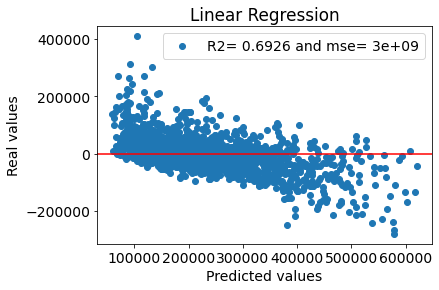

In [498]:
models_dict['Linear Regression'] = line_regression_model
model_test(line_regression_model, 'Linear Regression', X_test, y_test)

### Сохранение файлов

In [499]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8881 entries, 0 to 8880
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Id                                     8881 non-null   object 
 1   DistrictId                             8881 non-null   object 
 2   Rooms                                  8881 non-null   float64
 3   Square                                 8881 non-null   float64
 4   LifeSquare                             8881 non-null   float64
 5   KitchenSquare                          8881 non-null   float64
 6   Floor                                  8881 non-null   int64  
 7   HouseFloor                             8881 non-null   float64
 8   HouseYear                              8881 non-null   int64  
 9   Ecology_1                              8881 non-null   float64
 10  Ecology_2                              8881 non-null   object 
 11  Ecol

### Обработка данных в test_df

In [500]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)


test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [501]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [502]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [503]:
cat_colnames = test_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [504]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [505]:
test_df.loc[test_df['Rooms'].isin([0, 10, 17]), 'Rooms'] = test_df['Rooms'].median()
test_df['Rooms'].value_counts().sort_index()

1.0    1769
2.0    2033
3.0    1099
4.0      90
5.0       7
6.0       2
Name: Rooms, dtype: int64

In [506]:
test_df["LifeSquare"].isnull().sum()

1041

In [507]:
np.clip(
    a=test_df["LifeSquare"].dropna(),
    a_min=20,
    a_max=150
)

test_df = test_df[test_df['Square'].isnull() |
                    (test_df['Square'] < test_df['Square'].quantile(.99)) &
                    (test_df['Square'] > test_df['Square'].quantile(.01))]

test_df = test_df[test_df['LifeSquare'].isnull() |
                    (test_df['LifeSquare'] < test_df['LifeSquare'].quantile(.99)) &
                    (test_df['LifeSquare'] > test_df['LifeSquare'].quantile(.01))]

test_df = test_df[test_df['KitchenSquare'].isnull() |
                    (test_df['KitchenSquare'] < test_df['KitchenSquare'].quantile(.99)) &
                    (test_df['KitchenSquare'] > test_df['KitchenSquare'].quantile(.01))]

In [508]:
test_df.describe()


,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,4447.000000,4447.000000,3652.000000,4447.000000,4447.000000,4447.000000,4447.000000,4447.000000,4447.000000,4447.000000,4447.000000,2408.000000,4447.000000,4447.000000
mean,1.905779,55.150882,35.040202,6.063638,8.554981,12.777828,1984.030358,0.120233,26.145042,5644.405892,8.627839,1161.463040,1.389926,4.431527
std,0.790395,16.344318,14.377073,3.431909,5.405931,6.336609,18.520131,0.119908,17.301028,3998.022400,24.352123,1053.126231,1.481773,4.811164
min,1.000000,30.062518,2.819415,1.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774920,23.190911,4.000000,4.000000,9.000000,1972.000000,0.019509,11.000000,2370.000000,0.000000,325.000000,0.000000,1.000000
50%,2.000000,52.034775,32.631811,6.000000,7.000000,12.000000,1977.000000,0.075779,25.000000,5562.000000,2.000000,900.000000,1.000000,3.000000
75%,2.000000,65.322366,44.306318,9.000000,12.000000,17.000000,1999.000000,0.195781,37.000000,7614.000000,5.000000,1575.000000,3.000000,6.000000
max,5.000000,115.008223,85.621397,13.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


In [509]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()
test_df.loc[test_df['HouseFloor'] == 99, 'HouseFloor'] = test_df['HouseFloor'].median()
test_df['HouseFloor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 29., 30., 31., 32., 33., 37., 39., 40., 48.])

In [510]:
floor_outliers_test = test_df[test_df['Floor'] > test_df['HouseFloor']].index

test_df.loc[floor_outliers_test, 'Floor'] = test_df.loc[floor_outliers_test, 'HouseFloor'].apply(
    lambda x: random.randint(1, x)
)


In [511]:
len(test_df) - test_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare        795
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2039
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [512]:
square_med_diff_for_test = (test_df.loc[test_df['LifeSquare'].notnull(), 'Square'] -\
                   test_df.loc[test_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   test_df.loc[test_df['LifeSquare'].notnull(), 'KitchenSquare']).median()
square_med_diff_for_test

11.498123113715016

In [513]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] =\
test_df.loc[test_df['LifeSquare'].isnull(), 'Square'] -\
test_df.loc[test_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff_for_test

In [514]:
len(test_df) - test_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2039
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [515]:
test_df['Healthcare_1'].value_counts()

540.0     201
30.0      155
1046.0    111
2300.0     74
240.0      72
         ... 
32.0        7
200.0       7
920.0       4
35.0        2
0.0         1
Name: Healthcare_1, Length: 79, dtype: int64

In [516]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = 9
test_df['Healthcare_1'].value_counts()

9.0       2039
540.0      201
30.0       155
1046.0     111
2300.0      74
          ... 
32.0         7
200.0        7
920.0        4
35.0         2
0.0          1
Name: Healthcare_1, Length: 80, dtype: int64

In [517]:
gp = test_df.groupby(["Rooms"])["Square"].mean()
test_df["Mean_Square_by_rooms"] = test_df["Rooms"].map(gp.to_dict())

test_df["diff_square_and_mean_square_by_rooms"] = test_df["Square"] - test_df["Mean_Square_by_rooms"]
test_df["ratio_square_and_mean_square_by_rooms"] = test_df["Square"] / test_df["Mean_Square_by_rooms"] - 1
test_df.head(n=2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,11,2748,1,9.0,0,0,B,55.679869,-5.797225,-0.104117
1,15856,74,2.0,69.263183,56.765060,1.0,1,1.0,1977,0.075779,...,6,1437,3,9.0,0,2,B,55.679869,13.583315,0.243954


In [518]:
test_df["bigger_then_mean"] = np.where(
    test_df["diff_square_and_mean_square_by_rooms"] > 0, 1, 0)

In [519]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [520]:
district_size_for_test = test_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size_for_test.head()

,DistrictId,DistrictSize
0,27,292
1,1,285
2,23,211
3,6,201
4,9,125


In [521]:
test_df = test_df.merge(district_size_for_test, on='DistrictId', how='left')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4447 entries, 0 to 4446
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Id                                     4447 non-null   object 
 1   DistrictId                             4447 non-null   object 
 2   Rooms                                  4447 non-null   float64
 3   Square                                 4447 non-null   float64
 4   LifeSquare                             4447 non-null   float64
 5   KitchenSquare                          4447 non-null   float64
 6   Floor                                  4447 non-null   int64  
 7   HouseFloor                             4447 non-null   float64
 8   HouseYear                              4447 non-null   int64  
 9   Ecology_1                              4447 non-null   float64
 10  Ecology_2                              4447 non-null   object 
 11  Ecol

In [522]:
(test_df['DistrictSize'] > 100).value_counts(), (test_df['DistrictSize'] > 100).value_counts()
test_df['IsDistrictLarge'] = (test_df['DistrictSize'] > 100).astype(int)
test_features = list(X_train.columns)
test_df['MedPriceByDistrict'] = X_train['MedPriceByDistrict']
test_df['Rooms_vc'] = X_train['Rooms_vc']
test_features

['MedPriceByDistrict',
 'Square',
 'Mean_Square_by_rooms',
 'Rooms',
 'Rooms_vc',
 'LifeSquare',
 'DistrictSize',
 'IsDistrictLarge',
 'KitchenSquare',
 'Social_1',
 'Helthcare_2',
 'diff_square_and_mean_square_by_rooms',
 'Social_2',
 'ratio_square_and_mean_square_by_rooms',
 'bigger_then_mean',
 'Shops_1',
 'Healthcare_1',
 'Floor',
 'HouseFloor',
 'Social_3',
 'Ecology_1',
 'Shops_2_bin',
 'Ecology_3_bin',
 'Ecology_2_bin',
 'HouseYear']

In [523]:
test_df[test_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4447 entries, 0 to 4446
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MedPriceByDistrict                     3105 non-null   float64
 1   Square                                 4447 non-null   float64
 2   Mean_Square_by_rooms                   4447 non-null   float64
 3   Rooms                                  4447 non-null   float64
 4   Rooms_vc                               3105 non-null   float64
 5   LifeSquare                             4447 non-null   float64
 6   DistrictSize                           4447 non-null   int64  
 7   IsDistrictLarge                        4447 non-null   int32  
 8   KitchenSquare                          4447 non-null   float64
 9   Social_1                               4447 non-null   int64  
 10  Helthcare_2                            4447 non-null   int64  
 11  diff

In [524]:

#train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()
test_df.loc[test_df['Rooms_vc'].isnull(), 'Rooms_vc'] = test_df['Rooms_vc'].median()
test_df.loc[test_df['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test_df['MedPriceByDistrict'].median()

In [525]:
test_df['Price'] = line_regression_model.predict(test_df[test_features])

In [526]:
test_df[['Id', 'Price']].to_csv('NProts_predictions.csv', index=None)